In [37]:
import glob
import os
import numpy as np
import pandas as pd
import sys

from collections import OrderedDict

from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
# %matplotlib qt5

import config 
sys.path.append('./models/v1model/')
from plotting import _get_barplot
from utils import turn_tex
turn_tex('on')

path = '/run/media/loaloa/lbb_ssd/primitives/processed2/results/'

In [56]:
design_namemap = OrderedDict({               # r     $d
    'Prim01.1': {
        0: '2um, 15um',
        1: '3.5um, 15um',
        # 2: '3.5um, r1',
        3: '5.5um, 15um',
        
        4: '2um, 25um',
        5: '2.5um, 25um',
        6: '3.5um, 25um',
        7: '5.5um, 25um',
        
        8:  '2um, inf',
        9:  '3.5um, inf',
        # 10: '3.5um, r3',
        11: '5.5um, inf',
        
        12: 'neg. control',
    },

    'Prim01.2': {

        0: '5um',
        1: '10um',
        2: '15um',
        3: '20um',
        # 4: '20um',
        5: '40um',
    },

    'Prim02': {
        0: 'W:0.5um - H:6um',
        1: 'W:0.75um - H:6um',
        2: 'W:1um - H:6um',
        3: 'W:1.25um - H:6um',
        4: 'W:1.5um - H:6um',
        5: 'W:1.75um - H:6um',
        6: 'W:2um - H:6um',
        7: 'W:3um - H:6um',
        8: 'W:4um - H:6um',
        9: 'W:6um - H:6um',
        10: 'W:8um - H:6um',
        11: 'W:10um - H:6um',
        12: 'W:14um - H:6um',
        13: 'W:18um - H:6um',
        14: 'W:22um - H:6um',
        15: 'W:26um - H:6um',
        16: 'W:0.5um - H:24um',
        17: 'W:0.75um - H:24um',
        18: 'W:1um - H:24um',
        19: 'W:1.25um - H:24um',
        20: 'W:1.5um - H:24um',
        21: 'W:1.75um - H:24um',
        22: 'W:2um - H:24um',
        23: 'W:3um - H:24um',
        24: 'W:4um - H:24um',
        25: 'W:6um - H:24um',
        26: 'W:8um - H:24um',
        27: 'W:10um - H:24um',
        28: 'W:14um - H:24um',
        29: 'W:18um - H:24um',
        30: 'W:22um - H:24um',
        31: 'W:26um - H:24um',
    },

    'Prim03': {
        0:  '480um x 12/12',
        1:  '480um x 12/11',
        2:  '480um x 12/10',
        3:  '480um x 12/9',
        4:  '480um x 12/8',
        5:  '480um x 12/7',
        6:  '480um x 12/6',
        7:  '480um x 12/5',
        8:  '480um x 12/4',
        9:  '480um x 12/3',
        10: '480um x 12/2',
    },

    'Prim04': {
        5: '04_spikes',
        4: '02_spikes',
        2: '10_hills',
        0: '02_hills',
        1: '04_hills',
        6: '06_spikes',
        7: '10_spikes',
        3: 'neg_control',
    },

    'Prim05': {
        7: 'backward rescue loops angled',
        6: 'forward rescue loops angled',

        2: 'backward rescue loops',
        3: 'forward rescue loops',

        1: 'backward stomache',
        8: 'forward stomache',

        4: 'backward negative control',
        5: 'forward negative control',
    },

    'Prim06': {


        4: 'angled entry',

        3: '5um opening',

        6: 'inlay',
        2: '3um opening',
        7: 'tangential entry',
        8: '2x size',
        5: '1.5um opening',

        1: 'negative control',
    },
})

In [57]:
primitives_namemap = {
    'Prim03': 'Cue gradient',
    'Prim05': 'Directionality constrain',
    'Prim01.1': 'Edge transition',
    'Prim01.2': 'Radial detachment',
    'Prim04': 'Edge attachment',
    'Prim06': 'Joining channels',
    'Prim02': 'Growth speed',
}

In [58]:
metrics_files = sorted(glob.glob(f'{path}/*/*_metrics.csv'))
data = []
# iterate over the primitves
print(primitives_namemap)
for orig_name, new_name in primitives_namemap.items():
    # get the metrics files corresponding to this prim
    m_files = [f for f in metrics_files if orig_name in f]
    
    # unpack div14, and div7 files and format them for glue up
    if len(m_files) == 2:
        div14_mtrc, div7_mtrc = [pd.read_csv(f, index_col=(0,1)) for f in m_files]
        metrics_dfs = [pd.read_csv(f, index_col=(0,1)) for f in m_files]

        for metr_df, div in zip(metrics_dfs, (14, 7)):
            metr_df = metr_df.unstack(level=1).droplevel(axis=1, level=0)
            # replace the design ID with the actual design name, add DIV to index
            new_idx = [(new_name, div, design_namemap[orig_name][idx]) for idx in metr_df.index]
            metr_df.index = pd.MultiIndex.from_tuples(new_idx, names=('exp_name', 'DIV', 'design'))
            
            # reorder to the design_namemap if unique
            if ~pd.Index(design_namemap[orig_name].values()).duplicated().any():
                metr_df = metr_df.reindex(design_namemap[orig_name].values(), level='design')
            data.append(metr_df)

    elif len(m_files) == 0:
        print(f'Warning: `{orig_name}` not found in list of metric files.\n')
    elif len(m_files) > 2:
        print(f'Error: `{orig_name}` had more than 2 (DIV7, DIV14) metric files.\n')
        exit()

        
data_final = pd.concat(data, axis=0)
data_final.to_csv(f'{path}/all_primitives_results.csv')
data_final

{'Prim03': 'Cue gradient', 'Prim05': 'Directionality constrain', 'Prim01.1': 'Edge transition', 'Prim01.2': 'Radial detachment', 'Prim04': 'Edge attachment', 'Prim06': 'Joining channels', 'Prim02': 'Growth speed'}


replicate                               0         1         2         3   \
exp_name     DIV design                                                    
Cue gradient 14  480um x 12/12   -0.017450  0.005325 -0.041166 -0.054321   
                 480um x 12/11   -0.042236 -0.009601 -0.025739       NaN   
                 480um x 12/10   -0.051270       NaN       NaN  0.012970   
                 480um x 12/9    -0.008963       NaN       NaN       NaN   
                 480um x 12/8    -0.118023 -0.010251 -0.051707  0.100540   
...                                    ...       ...       ...       ...   
Growth speed 7   W:10um - H:24um       NaN       NaN  0.031330  0.038363   
                 W:14um - H:24um  0.480818       NaN  0.514066  0.064578   
                 W:18um - H:24um  0.322890       NaN  0.023657  0.075448   
                 W:22um - H:24um       NaN  0.631713       NaN  0.054987   
                 W:26um - H:24um  0.086956  0.146419  0.111892  0.407928   

replicate                               4         5         6         7   \
exp_name     DIV design                                                    
Cue gradient 14  480um x 12/12   -0.226147 -0.011515       NaN       NaN   
                 480um x 12/11   -0.066772  0.047119       NaN       NaN   
                 480um x 12/10   -0.035902 -0.055908 -0.093018 -0.040790   
                 480um x 12/9    -0.040493       NaN  0.033080 -0.127930   
                 480um x 12/8     0.161038  0.055486       NaN       NaN   
...                                    ...       ...       ...       ...   
Growth speed 7   W:10um - H:24um       NaN       NaN       NaN  0.104220   
                 W:14um - H:24um       NaN       NaN  0.079284  0.251279   
                 W:18um - H:24um       NaN       NaN  0.263427  0.312020   
                 W:22um - H:24um       NaN       NaN       NaN  0.340153   
                 W:26um - H:24um       NaN       NaN       NaN  0.206522   

replicate                               8   9   ...  22  23  24  25  26  27  \
exp_name     DIV design                         ...                           
Cue gradient 14  480um x 12/12         NaN NaN  ... NaN NaN NaN NaN NaN NaN   
                 480um x 12/11         NaN NaN  ... NaN NaN NaN NaN NaN NaN   
                 480um x 12/10         NaN NaN  ... NaN NaN NaN NaN NaN NaN   
                 480um x 12/9          NaN NaN  ... NaN NaN NaN NaN NaN NaN   
                 480um x 12/8          NaN NaN  ... NaN NaN NaN NaN NaN NaN   
...                                    ...  ..  ...  ..  ..  ..  ..  ..  ..   
Growth speed 7   W:10um - H:24um  0.104220 NaN  ... NaN NaN NaN NaN NaN NaN   
                 W:14um - H:24um  0.251279 NaN  ... NaN NaN NaN NaN NaN NaN   
                 W:18um - H:24um  0.312020 NaN  ... NaN NaN NaN NaN NaN NaN   
                 W:22um - H:24um  0.340153 NaN  ... NaN NaN NaN NaN NaN NaN   
                 W:26um - H:24um  0.206522 NaN  ... NaN NaN NaN NaN NaN NaN   

replicate                         28  29  30  31  
exp_name     DIV design                           
Cue gradient 14  480um x 12/12   NaN NaN NaN NaN  
                 480um x 12/11   NaN NaN NaN NaN  
                 480um x 12/10   NaN NaN NaN NaN  
                 480um x 12/9    NaN NaN NaN NaN  
                 480um x 12/8    NaN NaN NaN NaN  
...                               ..  ..  ..  ..  
Growth speed 7   W:10um - H:24um NaN NaN NaN NaN  
                 W:14um - H:24um NaN NaN NaN NaN  
                 W:18um - H:24um NaN NaN NaN NaN  
                 W:22um - H:24um NaN NaN NaN NaN  
                 W:26um - H:24um NaN NaN NaN NaN  

[166 rows x 32 columns]

In [207]:
# %matplotlib qt5
def get_yticks(exp_name):
    ylim, yticks = None, None
    if exp_name == 'Joining channels':
        ylim = -.1, .45
        yticks = np.round([-.1, 0, .1, .2, .3], 1)
    if exp_name == 'Radial detachment':
        ylim = -.15, .45
        yticks = np.round([-.1, 0, .1, .2, .3], 1)
    if exp_name == 'Edge transition':
        ylim = -.15, .45
        yticks = np.round([-.1, 0, .1, .2, .3], 1)
    if exp_name == 'Edge attachment':
        ylim = -.15, .35
        yticks = np.round([-.1, 0, .1, .2], 1)
    if exp_name == 'Growth speed':
        ylim = 0, 1.3
        yticks = np.round([0, .5, 1], 1)
    if exp_name == 'Directionality constrain':
        ylim = -1.8, 1.8
        yticks = np.round([-1, -.5, 0, .5, 1], 1)
    if exp_name == 'Cue gradient':
        ylim = -.4, .4
        yticks = np.round([-.4, -.2, 0, .2, .4], 1)

    return ylim, yticks

def singles_xlocs(xloc, n, spread):
    return np.random.normal(xloc, spread, n)

def draw_data(ax, dat, xloc, draw_boxplot=True, draw_vline=800, draw_bar=False, faint_boxplot=False,
              draw_singles=config.BAR_WIDTH/14, color='gray', median_col=config.DEFAULT_COLORS[1],
              width=config.BAR_WIDTH, singles_marker='.', marker_size=5):
    if draw_boxplot:
        bp = ax.boxplot(dat.values, widths=width, positions=(xloc,), patch_artist=True, 
                        showfliers=False, zorder=7)
        bp['medians'][0].set_color('none')
        bp['boxes'][0].set_facecolor(color)
        if faint_boxplot:
            bp['boxes'][0].set_alpha(.65)
            bp['whiskers'][0].set_alpha(.3)
            bp['whiskers'][1].set_alpha(.3)
            bp['caps'][0].set_alpha(.3)
            bp['caps'][1].set_alpha(.3)

    if draw_vline:
        ax.scatter(xloc, np.median(dat), linewidth=2.5, marker='_', s=draw_vline, zorder=9, color=median_col)

    if draw_bar:
        ax.bar(xloc, np.median(dat), width=config.BAR_WIDTH, color=color, edgecolor='k')

    if draw_singles:
        ax.scatter(singles_xlocs(xloc, len(dat), spread=draw_singles), dat, alpha=.35, s=marker_size, color='k', zorder=8, marker=singles_marker)

def save_plot(fig, exp, postfix=''):
    os.makedirs(f'{path}/final_plots/', exist_ok=True)
    fname = f'{path}/final_plots/{exp.replace(" ", "_")}{postfix}.{config.FIGURE_FILETYPE}'
    fig.savefig(fname)

    
def get_plot(data, div='split', exp_name='', designs=None, plot_kwargs={}, xtl_xl=None, postfix=''):
    if designs is None:
        designs = data.index.unique('design')
    design_centers = np.arange(len(designs)) if div != 'split' else np.arange(0, len(designs)*2, 2)
    fig, ax = _get_barplot(len(design_centers), False, True)

    for d, xloc in zip(designs, design_centers):
        if div in (7,14):
            dat = data.loc[(div, d),:]
        elif div in ('split', 'merge'):
            dat = data.loc[(slice(None), d),:]
            if div == 'merge':
                dat = dat.stack()
        
        # draw data
        if div != 'split':
            col = 'grey' if not 'control' in d else 'none'
            col = col if not 'hills' in d else config.LIGHT_GRAY
            draw_data(ax, dat.dropna(), xloc, color=col, **plot_kwargs)
        else:
            draw_data(ax, dat.loc[7].T.dropna(), xloc-config.BAR_WIDTH/2, **plot_kwargs)
            draw_data(ax, dat.loc[14].T.dropna(), xloc+config.BAR_WIDTH/2, **plot_kwargs)

    # setup y
    ylim, yticks = get_yticks(exp_name)
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks, fontsize=config.SMALL_FONTS)
    ax.tick_params(labelsize=config.SMALL_FONTS)
    ax.set_ylabel('directionality metric', fontsize=config.FONTS)
    ax.grid(axis='y', zorder=11)
    
    # setup x
    if xtl_xl is None:
        ax.set_xticks(design_centers)
        ax.set_xticklabels(designs, rotation=35, ha='right', fontsize=config.FONTS)
    else:
        ax.set_xticklabels(xtl_xl[0], rotation=35, ha='right', fontsize=config.FONTS)
        ax.set_xlabel(xtl_xl[1], fontsize=config.FONTS, y=-.08)
    ax.set_title(f'{exp}, DIV:{div}', fontsize=config.FONTS)
    save_plot(fig, exp, postfix=postfix)
    

In [208]:
def get_growth_speed_plot(data, exp_name, div='merge', ylabel='', xtl_xl_xlim=None, plot_kwargs={}, fitline=False, postfix=''):
    numeric_namemap = {
    'Growth speed': {
        'W:0.5um - H:6um': .5,
        'W:0.75um - H:6um': .75,
        'W:1um - H:6um': 1,
        'W:1.25um - H:6um': 1.25,
        'W:1.5um - H:6um': 1.5,
        'W:1.75um - H:6um': 1.75,
        'W:2um - H:6um': 2,
        'W:3um - H:6um': 3,
        'W:4um - H:6um': 4,
        'W:6um - H:6um': 6,
        'W:8um - H:6um': 6,
        'W:10um - H:6um': 6,
        'W:14um - H:6um': 6,
        'W:18um - H:6um': 6,
        'W:22um - H:6um': 6,
        'W:26um - H:6um': 6,
        'W:0.5um - H:24um': 0.5,
        'W:0.75um - H:24um': 0.75,
        'W:1um - H:24um': 1,
        'W:1.25um - H:24um': 1.25,
        'W:1.5um - H:24um': 1.5,
        'W:1.75um - H:24um': 1.75,
        'W:2um - H:24um': 2,
        'W:3um - H:24um': 3,
        'W:4um - H:24um': 4,
        'W:6um - H:24um': 6,
        'W:8um - H:24um': 8,
        'W:10um - H:24um': 10,
        'W:14um - H:24um': 14,
        'W:18um - H:24um': 18,
        'W:22um - H:24um': 22,
        'W:26um - H:24um': 24,
    },
    'Cue gradient': {
        '480um x 12/12': 12/12,
        '480um x 12/11': 12/11,
        '480um x 12/10': 12/10,
        '480um x 12/9': 12/9,
        '480um x 12/8': 12/8,
        '480um x 12/7': 12/7,
        '480um x 12/6': 12/6,
        '480um x 12/5': 12/5,
        '480um x 12/4': 12/4,
        '480um x 12/3': 12/3,
        '480um x 12/2': 12/2,
    }}
    data = data.copy()
    data.index = pd.MultiIndex.from_tuples([(DIV, numeric_namemap[exp_name][d]) for DIV, d in data.index],
                                           names=('DIV', 'design'))

    fig, ax = plt.subplots(figsize=(6, config.BARPLOT_HEIGHT))
    margins = {'bottom':.35, 'top':.9}
    fig.subplots_adjust(**margins)

    if div in (7,14):
        data = data.loc[[div],:]
    data = data.stack()
    designs = data.index.unique('design')

    for i, d in enumerate(designs):
        dat = data.loc[(slice(None),d)]
        if len(dat) >3:
            width = config.BAR_WIDTH/7 if exp == 'Growth speed' else config.BAR_WIDTH/10
            width = 10**(np.log10(d)+width/4.)-10**(np.log10(d)-width/4.)
            draw_data(ax, dat, d, faint_boxplot=True, width=width, draw_boxplot=True, draw_singles=1/100, 
                      draw_vline=100, color=config.LIGHT_GRAY)
        
    if fitline:
        x = data.index.get_level_values('design').values.astype(float)
        y = data.values
        f = np.poly1d(np.polyfit(x, y, 4))
        x_new = np.linspace(x[0], x[-1], 50)
        ax.plot(x_new, f(x_new), color=config.DEFAULT_COLORS[1], linestyle='dashed', 
                alpha=.7, linewidth=2)

    # setup y
    ylim, yticks = get_yticks(exp_name)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=config.SMALL_FONTS)

    ax.tick_params(labelsize=config.SMALL_FONTS)
    ax.set_ylabel(ylabel, fontsize=config.FONTS)
    ax.grid(axis='y', zorder=1)
    
    # # setup x
    ax.set_xscale('log')
    ax.set_xticks(np.array(designs, float))
    ax.set_xlim(xtl_xl_xlim[2])
    xtl = [l if l in xtl_xl_xlim[0] else '' for l in designs.to_list()]
    ax.set_xticklabels(xtl, fontsize=config.FONTS)
    ax.set_xlabel(xtl_xl_xlim[1], fontsize=config.FONTS, y=-.08)
    ax.set_title(f'{exp_name}, DIV:{div}', fontsize=config.FONTS)

    save_plot(fig, exp, postfix=postfix)

In [211]:
def get_directionality_plot(data, div='split', exp_name='', designs=None, plot_kwargs={}, postfix=''):
    if designs is None:
        designs = data.index.unique('design')
    design_centers = np.arange(len(designs))
    fig, ax = _get_barplot(len(design_centers), False, True)

    # setup y
    ylim, yticks = get_yticks(exp_name)
    ymin, ymax = ylim
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=config.SMALL_FONTS)
    ax.tick_params(labelsize=config.SMALL_FONTS)
    ax.set_ylabel('directionality metric', fontsize=config.FONTS)
    ax.grid(axis='y', zorder=11)

    # iterate over units
    for d, xloc in zip(designs, design_centers):
        if div in (7,14):
            dat = data.loc[(div, d),:]
        elif div in ('split', 'merge'):
            dat = data.loc[(slice(None), d),:]
            if div == 'merge':
                dat = dat.stack()
        
        # draw data
        col = config.LIGHT_GRAY if not 'control' in d else 'none'
        color = config.LIGHT_GRAY if 'control' not in xtl_xl[0][xloc] else 'none'
        
        forw_mask = np.array([des.startswith('forward') for des in dat.index.get_level_values('design')])
        forw_dat = dat[forw_mask]
        draw_data(ax, forw_dat, xloc+.06, width=config.BAR_WIDTH/2.5, color=color, faint_boxplot=True, 
                  draw_singles=.01, draw_vline=120, singles_marker='+', marker_size=30)
        
        backw_dat = dat[~forw_mask] * -1
        draw_data(ax, backw_dat, xloc-.06, width=config.BAR_WIDTH/2.5, color=color, faint_boxplot=True, 
                  draw_singles=.01, draw_vline=120, singles_marker='_', marker_size=30)

    # setup x
    ax.set_xlim(-.5, 3.5)
    ax.set_xticks(range(4))
    if xtl_xl is None:
        ax.set_xticks(design_centers)
        ax.set_xticklabels(designs, rotation=35, ha='right', fontsize=config.FONTS)
    else:
        ax.set_xticklabels(xtl_xl[0], fontsize=config.FONTS, rotation=35, ha='right',)
        ax.set_xlabel(xtl_xl[1], fontsize=config.FONTS, y=-.08)
    xmin, xmax = ax.get_xlim()
    ax.set_title(f'{exp}, DIV:{div}', fontsize=config.FONTS)

    # draw background
    ax.add_patch(Rectangle((xmin,0), xmax+1, ymax, color=config.GREEN, alpha=.1, zorder=1))
    ax.text(xmax, ymax-.15, 'correct direction', ha='right', va='center', fontsize=config.SMALL_FONTS)
    ax.add_patch(Rectangle((xmin,0), xmax+1, ymin, color=config.RED, alpha=.1, zorder=1))
    ax.text(xmax, ymin+.15, 'incorrect direction', ha='right', va='center', fontsize=config.SMALL_FONTS)

    save_plot(fig, exp, postfix=postfix)

Cue gradient
Directionality constrain
Edge transition
Radial detachment
Edge attachment
Joining channels
Growth speed


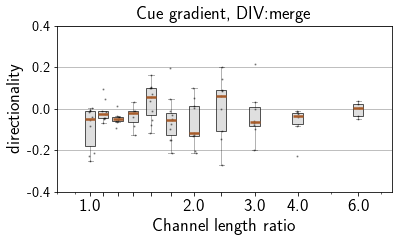

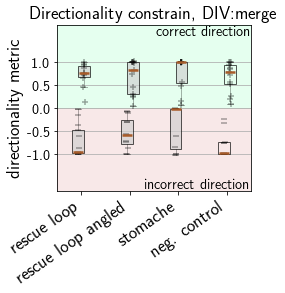

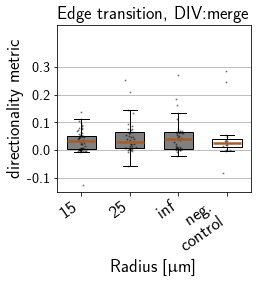

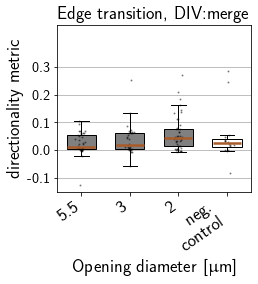

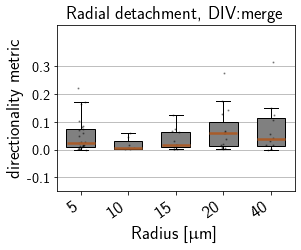

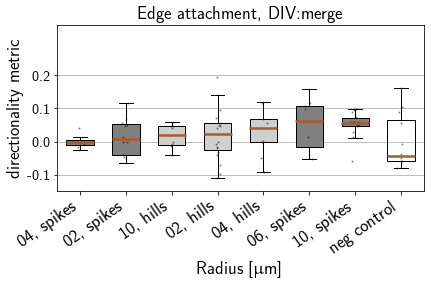

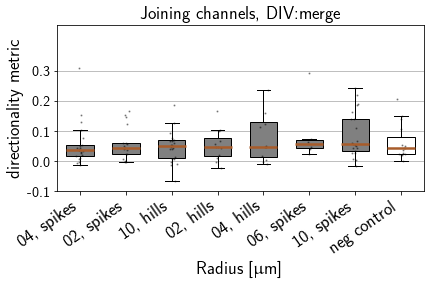

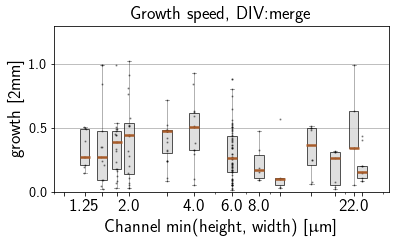

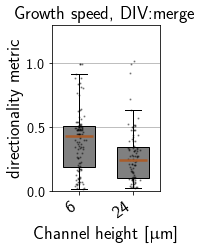

In [214]:
div = 'merge'
plot_kwargs = {'draw_boxplot': True}



for exp in data_final.index.unique('exp_name'):
    print(exp)
    exp_data = data_final.loc[exp]
    
    designs = None
    if exp == 'Edge transition':
        designs = (
        ['2um, 15um','3.5um, 15um','5.5um, 15um',],
        ['2um, 25um','3.5um, 25um','5.5um, 25um',],
        ['2um, inf','3.5um, inf','5.5um, inf',], 
        'neg. control',)
        xtl_xl = ('15', '25', 'inf', 'neg.\ncontrol'), f'Radius {config.um}'
        get_plot(exp_data, div, exp, designs, plot_kwargs, xtl_xl=xtl_xl, postfix='_radius')
        
        designs = (
        ['5.5um, 15um','5.5um, 25um','5.5um, inf',], 
        ['3um, 15um','3.5um, 25um','3.5um, inf',],
        ['2um, 15um','2um, 25um','2um, inf',],
        'neg. control',)
        xtl_xl = (5.5, 3, 2, 'neg.\ncontrol'), f'Opening diameter {config.um}'
        get_plot(exp_data, div, exp, designs, plot_kwargs, xtl_xl=xtl_xl, postfix='_diameter')

    elif exp == 'Cue gradient':
        xtl_xl_xlim = [1,2,3,4,5,6], 'Channel length ratio', (.8, 7.5)
        get_growth_speed_plot(exp_data, exp, div,  plot_kwargs=plot_kwargs, xtl_xl_xlim=xtl_xl_xlim, ylabel='directionality')

    elif exp == 'Growth speed':
        xtl_xl_xlim = [1.25,2,4,6,8,22], f'Channel min(height, width) {config.um}', (.9, 32)
        get_growth_speed_plot(exp_data, exp, div,  plot_kwargs=plot_kwargs, xtl_xl_xlim=xtl_xl_xlim, ylabel='growth [2mm]')

        designs = [('W:0.5um - H:6um', 'W:0.75um - H:6um', 'W:1um - H:6um', 'W:1.25um - H:6um', 'W:1.5um - H:6um', 'W:1.75um - H:6um', 'W:2um - H:6um', 'W:3um - H:6um', 'W:4um - H:6um', 'W:6um - H:6um', 'W:8um - H:6um', 'W:10um - H:6um', 'W:14um - H:6um', 'W:18um - H:6um', 'W:22um - H:6um', 'W:26um - H:6um',),
('W:0.5um - H:24um', 'W:0.75um - H:24um', 'W:1um - H:24um', 'W:1.25um - H:24um', 'W:1.5um - H:24um', 'W:1.75um - H:24um', 'W:2um - H:24um', 'W:3um - H:24um', 'W:4um - H:24um', 'W:6um - H:24um', 'W:8um - H:24um', 'W:10um - H:24um', 'W:14um - H:24um', 'W:18um - H:24um', 'W:22um - H:24um', 'W:26um - H:24um',)
        ]
        xtl_xl = (6, 24), f'Channel height {config.um}'
        get_plot(exp_data, div, exp, designs, plot_kwargs, xtl_xl=xtl_xl, postfix='_chnl_height')

    elif exp == 'Directionality constrain':
        designs = [
        ('backward rescue loops','forward rescue loops',),
        ('backward rescue loops angled','forward rescue loops angled',),
        ('backward stomache','forward stomache',),
        ('backward negative control','forward negative control',),
        ]
        xtl_xl = (['rescue loop', 'rescue loop angled', 'stomache',  'neg. control'], '')
        get_directionality_plot(exp_data, div, exp, designs, plot_kwargs)

    elif exp == 'Radial detachment':
        xtl_xl = ([5, 10, 15, 20, 40], f'Radius {config.um}')
        get_plot(exp_data, div, exp, designs, plot_kwargs, xtl_xl=xtl_xl)
    
    elif exp == 'Edge attachment':
        xtl_xl = (['04, spikes', '02, spikes', '10, hills', '02, hills', '04, hills', '06, spikes', '10, spikes', 'neg control',], f'Radius {config.um}')
        get_plot(exp_data, div, exp, designs, plot_kwargs, xtl_xl=xtl_xl)
    else:
        get_plot(exp_data, div, exp, designs, plot_kwargs)

        